# Libraries

In [91]:
!pip install yfinance pandas ta

In [92]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, KeltnerChannel

# Section 1

In [93]:
cryptos = ['BTC-USD', 'ETH-USD']

start_date = '2023-02-01'
end_date = '2024-02-01'

In [94]:
five_day_data = yf.download(cryptos, start=start_date, end=end_date, interval='5d')

print(five_day_data.head())

[*********************100%***********************]  2 of 2 completed

Price                         Adj Close                      Close  \
Ticker                          BTC-USD      ETH-USD       BTC-USD   
Date                                                                 
2023-02-01 00:00:00+00:00  23723.769531  1641.792725  23723.769531   
2023-02-06 00:00:00+00:00  22760.109375  1616.247070  22760.109375   
2023-02-11 00:00:00+00:00  21870.875000  1539.926758  21870.875000   
2023-02-16 00:00:00+00:00  23623.474609  1640.067627  23623.474609   
2023-02-21 00:00:00+00:00  24436.353516  1658.036377  24436.353516   

Price                                           High               \
Ticker                         ETH-USD       BTC-USD      ETH-USD   
Date                                                                
2023-02-01 00:00:00+00:00  1641.792725  23764.539062  1644.727539   
2023-02-06 00:00:00+00:00  1616.247070  23119.279297  1653.715454   
2023-02-11 00:00:00+00:00  1539.926758  21891.410156  1541.334717   
2023-02-16 00:00:00+00:00

In [95]:
five_day_data.columns = ['_'.join(col) for col in five_day_data.columns]

print(five_day_data.columns)

Index(['Adj Close_BTC-USD', 'Adj Close_ETH-USD', 'Close_BTC-USD',
       'Close_ETH-USD', 'High_BTC-USD', 'High_ETH-USD', 'Low_BTC-USD',
       'Low_ETH-USD', 'Open_BTC-USD', 'Open_ETH-USD', 'Volume_BTC-USD',
       'Volume_ETH-USD'],
      dtype='object')


In [96]:
def calculate_bollinger_bands(df, cryptos, window=20, multiplier=2):
    for crypto in cryptos:
        close = df[f'Close_{crypto}']
        sma = close.rolling(window=window).mean()
        std = close.rolling(window=window).std()
        df[f'Upper_Band_{crypto}'] = sma + (multiplier * std)
        df[f'Lower_Band_{crypto}'] = sma - (multiplier * std)
    return df

In [97]:
def calculate_keltner_channels(df, cryptos, window=20, window_atr=14, multiplier=2):

    for crypto in cryptos:
        high = df[f'High_{crypto}']
        low = df[f'Low_{crypto}']
        close = df[f'Close_{crypto}']

        tr1 = high - low
        tr2 = (high - close.shift(1)).abs()
        tr3 = (low - close.shift(1)).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        df[f'TR_{crypto}'] = tr

        atr = tr.rolling(window=window_atr, min_periods=window_atr).mean()
        df[f'ATR_{crypto}'] = atr

        sma = close.rolling(window=window, min_periods=window).mean()
        df[f'SMA_{crypto}'] = sma

        df[f'Keltner_Upper_{crypto}'] = sma + (multiplier * atr)

        df[f'Keltner_Lower_{crypto}'] = sma - (multiplier * atr)

    return df



In [98]:
def calculate_RSI_pandas(df, cryptos, window=7, ob=70, os=30):

    for crypto in cryptos:
      delta = df[f'Close_{crypto}'].diff()
      gain = delta.clip(lower=0)
      loss = -delta.clip(upper=0)

      avg_gain = gain.ewm(alpha=1/window, min_periods=window).mean()
      avg_loss = loss.ewm(alpha=1/window, min_periods=window).mean()

      rs = avg_gain / avg_loss
      rsi = 100 - (100 / (1 + rs))

      df[f'RSI_{crypto}'] = rsi

      df[f'RSI_Overbought_{crypto}'] = df[f'RSI_{crypto}'] > ob
      df[f'RSI_Oversold_{crypto}'] = df[f'RSI_{crypto}'] < os

    return df



In [99]:
def generate_trade_signals(df, cryptos):

    for crypto in cryptos:
        buy_condition = (
            (df[f'Close_{crypto}'] < df[f'Lower_Band_{crypto}']) &
            (df[f'Close_{crypto}'] < df[f'Keltner_Lower_{crypto}']) &
            (df[f'RSI_Oversold_{crypto}'])
        )

        sell_condition = (
            (df[f'Close_{crypto}'] > df[f'Upper_Band_{crypto}']) &
            (df[f'Close_{crypto}'] > df[f'Keltner_Upper_{crypto}']) &
            (df[f'RSI_Overbought_{crypto}'])
        )

        df[f'Buy_Signal_{crypto}'] = buy_condition
        df[f'Sell_Signal_{crypto}'] = sell_condition

    return df


In [100]:

def plot_trade_signals(df, crypto):

    plt.figure(figsize=(14, 7))

    plt.plot(df.index, df[f'Close_{crypto}'], label='Close Price', color='blue')

    plt.plot(df.index, df[f'Upper_Band_{crypto}'], label='Bollinger Upper Band', color='magenta', linestyle='--')
    plt.plot(df.index, df[f'Lower_Band_{crypto}'], label='Bollinger Lower Band', color='cyan', linestyle='--')

    plt.plot(df.index, df[f'Keltner_Upper_{crypto}'], label='Keltner Upper Channel', color='green', linestyle='--')
    plt.plot(df.index, df[f'Keltner_Lower_{crypto}'], label='Keltner Lower Channel', color='red', linestyle='--')

    buy_signals = df[df[f'Buy_Signal_{crypto}']]
    plt.scatter(buy_signals.index, buy_signals[f'Close_{crypto}'], marker='^', color='green', label='Buy Signal', s=100)

    sell_signals = df[df[f'Sell_Signal_{crypto}']]
    plt.scatter(sell_signals.index, sell_signals[f'Close_{crypto}'], marker='v', color='red', label='Sell Signal', s=100)

    plt.title(f'{crypto} Price with Bollinger Bands, Keltner Channels, and Trade Signals')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [101]:
def backtest_strategy(df, cryptos, initial_capital=1000):

    results = {}

    for crypto in cryptos:
        capital = initial_capital
        position = 0
        buy_price = 0
        shares = 0

        df[f'Portfolio_Value_{crypto}'] = initial_capital

        for idx, row in df.iterrows():
            close_price = row[f'Close_{crypto}']
            buy_signal = row[f'Buy_Signal_{crypto}']
            sell_signal = row[f'Sell_Signal_{crypto}']

            if buy_signal and position == 0:
                position = 1
                buy_price = close_price
                shares = capital / buy_price
                capital = 0
                portfolio_value = shares * close_price
                df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value
                print(f"{idx.date()} - {crypto}: خرید به قیمت {buy_price:.2f} USD")

            elif sell_signal and position == 1:
                position = 0
                sell_price = close_price
                capital = shares * sell_price
                shares = 0
                portfolio_value = capital
                df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value
                print(f"{idx.date()} - {crypto}: فروش به قیمت {sell_price:.2f} USD")

            else:
                if position == 1:
                    portfolio_value = shares * close_price
                else:
                    portfolio_value = capital
                df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value

        if position == 1:
            sell_price = df[f'Close_{crypto}'].iloc[-1]
            capital = shares * sell_price
            df.at[df.index[-1], f'Portfolio_Value_{crypto}'] = capital
            print(f"{df.index[-1].date()} - {crypto}: فروش نهایی به قیمت {sell_price:.2f} USD")

        df[f'Returns_{crypto}'] = df[f'Portfolio_Value_{crypto}'].pct_change().fillna(0)

        df[f'Cumulative_Returns_{crypto}'] = (1 + df[f'Returns_{crypto}']).cumprod()

        total_return = df[f'Cumulative_Returns_{crypto}'].iloc[-1] - 1
        net_profit = capital - initial_capital
        daily_returns = df[f'Returns_{crypto}']

        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

        negative_returns = daily_returns[daily_returns < 0]
        sortino_ratio = daily_returns.mean() / negative_returns.std() * np.sqrt(252) if not negative_returns.empty else np.nan

        cumulative = df[f'Cumulative_Returns_{crypto}']
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        max_drawdown = drawdown.min()

        results[crypto] = {
            'Total Return (%)': total_return * 100,
            'Net Profit ($)': net_profit,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown (%)': max_drawdown * 100
        }

    return results

## Parametes I

In [119]:
five_day_data = calculate_bollinger_bands(five_day_data, cryptos, window=20, multiplier=2)
five_day_data = calculate_keltner_channels(five_day_data, cryptos, window=20, window_atr=14, multiplier=2)
five_day_data = calculate_RSI_pandas(five_day_data, cryptos, ob=70, os=30)
five_day_data = generate_trade_signals(five_day_data, cryptos)
signal_columns = [f'Buy_Signal_{crypto}' for crypto in cryptos] + [f'Sell_Signal_{crypto}' for crypto in cryptos]

print(five_day_data[signal_columns].tail())

initial_capital = 1000
results = backtest_strategy(five_day_data, cryptos, initial_capital=initial_capital)

for crypto, metrics in results.items():
    print(f"\nنتایج Backtest برای {crypto}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

                           Buy_Signal_BTC-USD  Buy_Signal_ETH-USD  \
Date                                                                
2024-01-07 00:00:00+00:00               False               False   
2024-01-12 00:00:00+00:00               False               False   
2024-01-17 00:00:00+00:00               False               False   
2024-01-22 00:00:00+00:00               False               False   
2024-01-27 00:00:00+00:00               False               False   

                           Sell_Signal_BTC-USD  Sell_Signal_ETH-USD  
Date                                                                 
2024-01-07 00:00:00+00:00                False                False  
2024-01-12 00:00:00+00:00                False                False  
2024-01-17 00:00:00+00:00                False                False  
2024-01-22 00:00:00+00:00                False                False  
2024-01-27 00:00:00+00:00                False                False  
2023-08-20 - ETH-USD: خرید

<ipython-input-101-4bff43d23f00>:57: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '981.0565015648108' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value


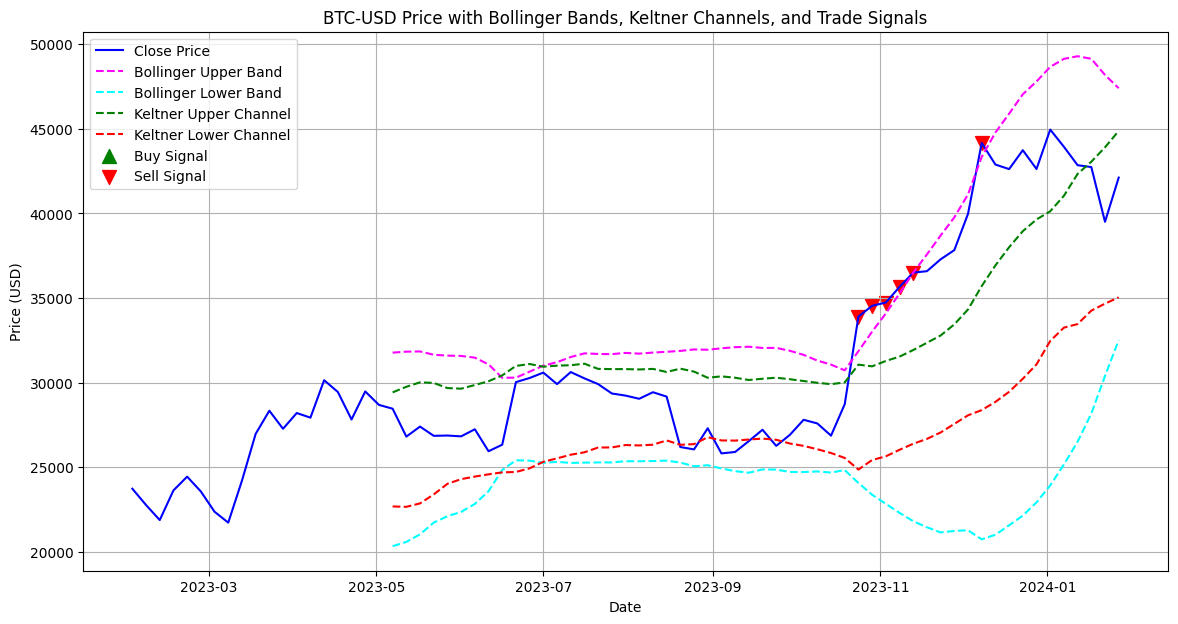

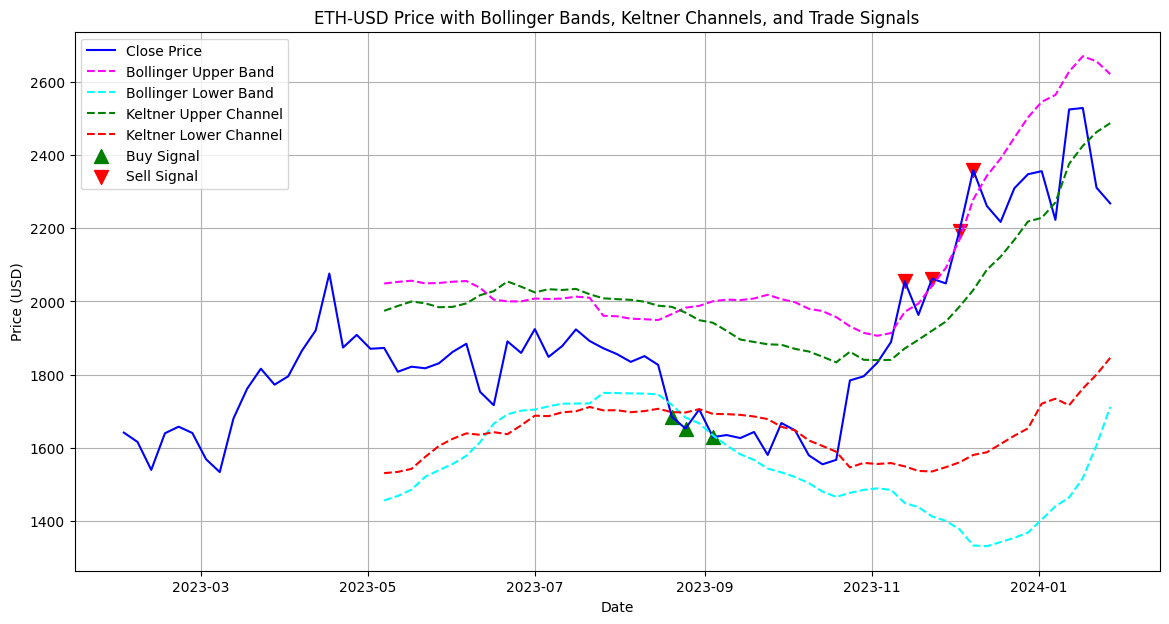

In [103]:
for crypto in cryptos:
    plot_trade_signals(five_day_data, crypto)

## Parameters II

In [120]:
five_day_data = calculate_bollinger_bands(five_day_data, cryptos, window=5, multiplier=2)
five_day_data = calculate_keltner_channels(five_day_data, cryptos, window=5, window_atr=14, multiplier=2)
five_day_data = calculate_RSI_pandas(five_day_data, cryptos, window=5, ob=70, os=30)
five_day_data = generate_trade_signals(five_day_data, cryptos)
signal_columns = [f'Buy_Signal_{crypto}' for crypto in cryptos] + [f'Sell_Signal_{crypto}' for crypto in cryptos]

print(five_day_data[signal_columns].tail())

initial_capital = 1000
results = backtest_strategy(five_day_data, cryptos, initial_capital=initial_capital)

for crypto, metrics in results.items():
    print(f"\nنتایج Backtest برای {crypto}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

                           Buy_Signal_BTC-USD  Buy_Signal_ETH-USD  \
Date                                                                
2024-01-07 00:00:00+00:00               False               False   
2024-01-12 00:00:00+00:00               False               False   
2024-01-17 00:00:00+00:00               False               False   
2024-01-22 00:00:00+00:00               False               False   
2024-01-27 00:00:00+00:00               False               False   

                           Sell_Signal_BTC-USD  Sell_Signal_ETH-USD  
Date                                                                 
2024-01-07 00:00:00+00:00                False                False  
2024-01-12 00:00:00+00:00                False                False  
2024-01-17 00:00:00+00:00                False                False  
2024-01-22 00:00:00+00:00                False                False  
2024-01-27 00:00:00+00:00                False                False  

نتایج Backtest برای BTC-U

<ipython-input-101-4bff43d23f00>:57: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)


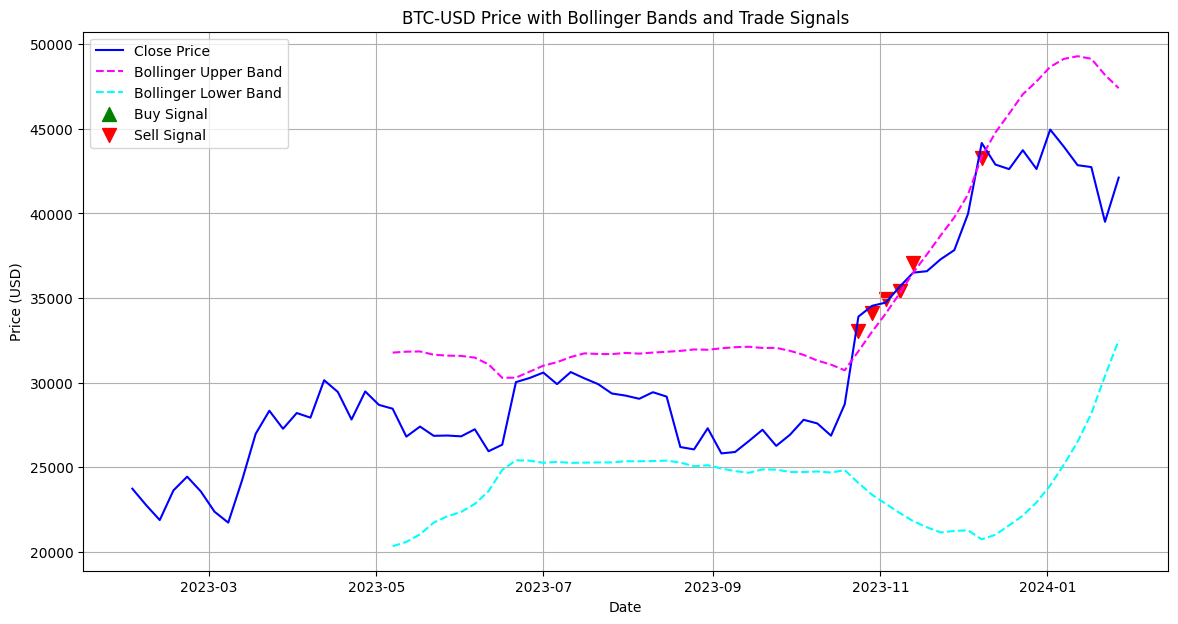

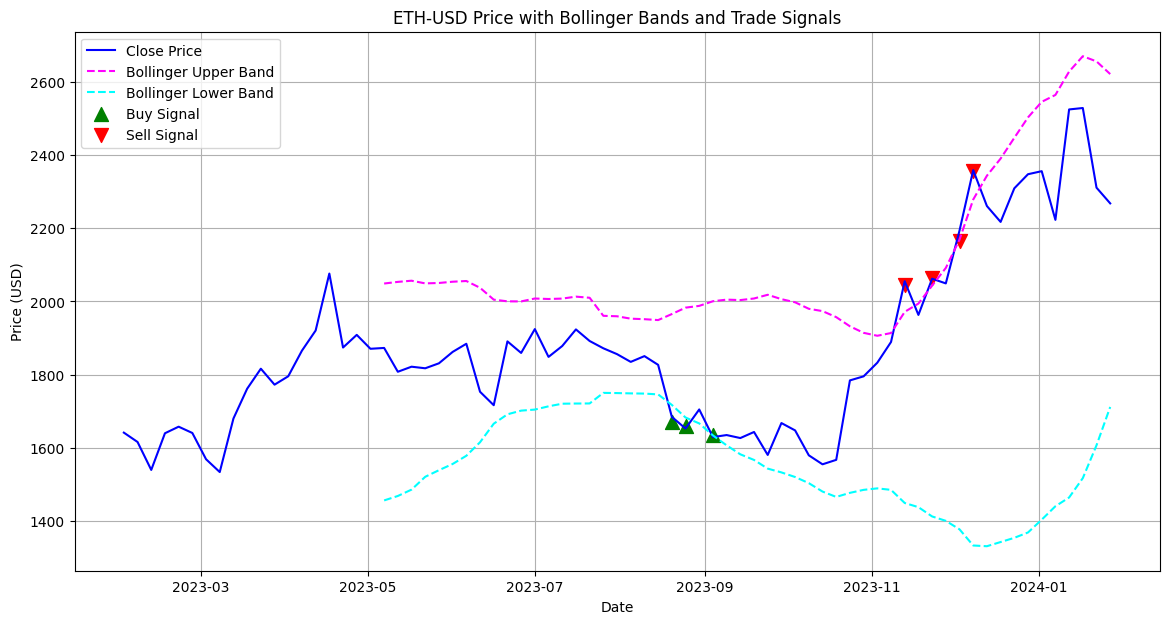

In [116]:
for crypto in cryptos:
    plot_trade_signals(five_day_data, crypto)

## Parameter III

In [121]:
five_day_data = calculate_bollinger_bands(five_day_data, cryptos, window=10, multiplier=1)
five_day_data = calculate_keltner_channels(five_day_data, cryptos, window=10, window_atr=14, multiplier=2)
five_day_data = calculate_RSI_pandas(five_day_data, cryptos, window=10, ob=70, os=30)
five_day_data = generate_trade_signals(five_day_data, cryptos)
signal_columns = [f'Buy_Signal_{crypto}' for crypto in cryptos] + [f'Sell_Signal_{crypto}' for crypto in cryptos]

print(five_day_data[signal_columns].tail())

initial_capital = 1000
results = backtest_strategy(five_day_data, cryptos, initial_capital=initial_capital)

for crypto, metrics in results.items():
    print(f"\nنتایج Backtest برای {crypto}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

                           Buy_Signal_BTC-USD  Buy_Signal_ETH-USD  \
Date                                                                
2024-01-07 00:00:00+00:00               False               False   
2024-01-12 00:00:00+00:00               False               False   
2024-01-17 00:00:00+00:00               False               False   
2024-01-22 00:00:00+00:00               False               False   
2024-01-27 00:00:00+00:00               False               False   

                           Sell_Signal_BTC-USD  Sell_Signal_ETH-USD  
Date                                                                 
2024-01-07 00:00:00+00:00                False                False  
2024-01-12 00:00:00+00:00                False                False  
2024-01-17 00:00:00+00:00                False                False  
2024-01-22 00:00:00+00:00                False                False  
2024-01-27 00:00:00+00:00                False                False  

نتایج Backtest برای BTC-U

<ipython-input-101-4bff43d23f00>:57: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)


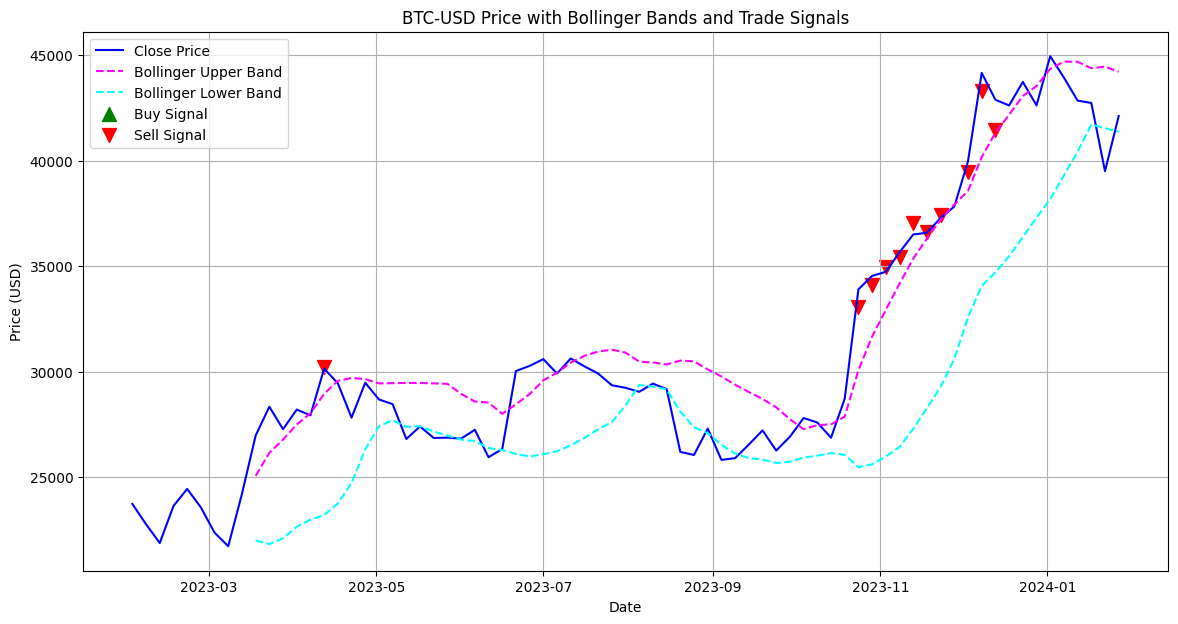

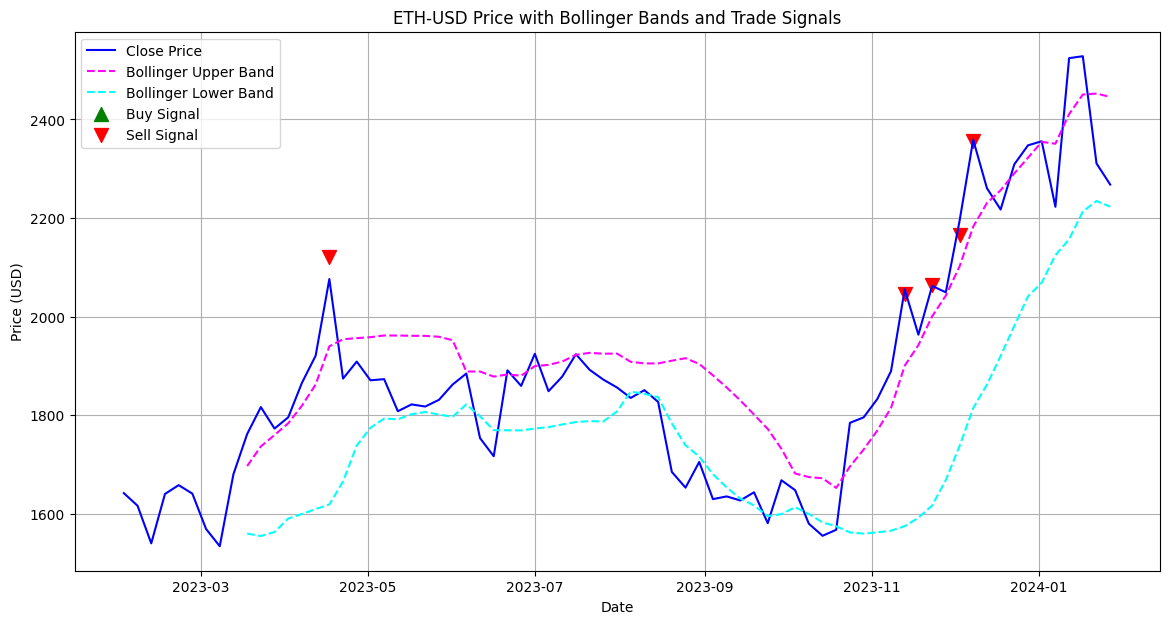

In [122]:
for crypto in cryptos:
    plot_trade_signals(five_day_data, crypto)

## Parametes IV

In [123]:
five_day_data = calculate_bollinger_bands(five_day_data, cryptos, window=20, multiplier=1)
five_day_data = calculate_keltner_channels(five_day_data, cryptos, window=20, window_atr=14, multiplier=2)
five_day_data = calculate_RSI_pandas(five_day_data, cryptos, ob=70, os=30)
five_day_data = generate_trade_signals(five_day_data, cryptos)
signal_columns = [f'Buy_Signal_{crypto}' for crypto in cryptos] + [f'Sell_Signal_{crypto}' for crypto in cryptos]

print(five_day_data[signal_columns].tail())

initial_capital = 1000
results = backtest_strategy(five_day_data, cryptos, initial_capital=initial_capital)

for crypto, metrics in results.items():
    print(f"\nنتایج Backtest برای {crypto}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

                           Buy_Signal_BTC-USD  Buy_Signal_ETH-USD  \
Date                                                                
2024-01-07 00:00:00+00:00               False               False   
2024-01-12 00:00:00+00:00               False               False   
2024-01-17 00:00:00+00:00               False               False   
2024-01-22 00:00:00+00:00               False               False   
2024-01-27 00:00:00+00:00               False               False   

                           Sell_Signal_BTC-USD  Sell_Signal_ETH-USD  
Date                                                                 
2024-01-07 00:00:00+00:00                 True                False  
2024-01-12 00:00:00+00:00                False                 True  
2024-01-17 00:00:00+00:00                False                 True  
2024-01-22 00:00:00+00:00                False                False  
2024-01-27 00:00:00+00:00                False                False  
2023-08-20 - BTC-USD: خرید

<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '994.581203897333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value
<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '981.0565015648108' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value


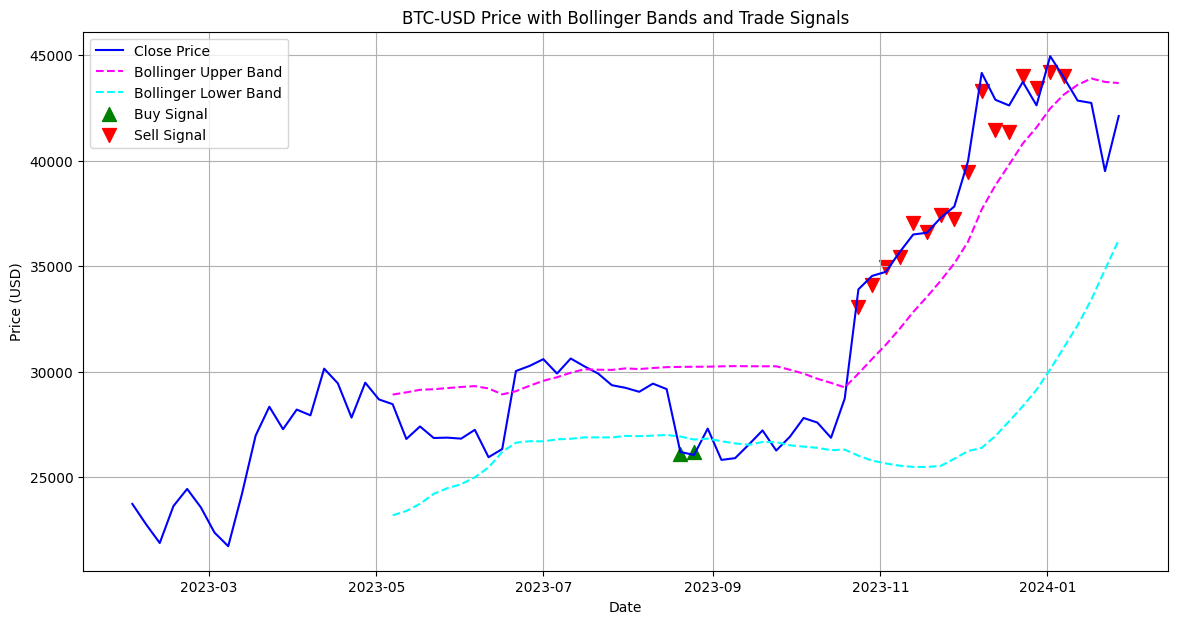

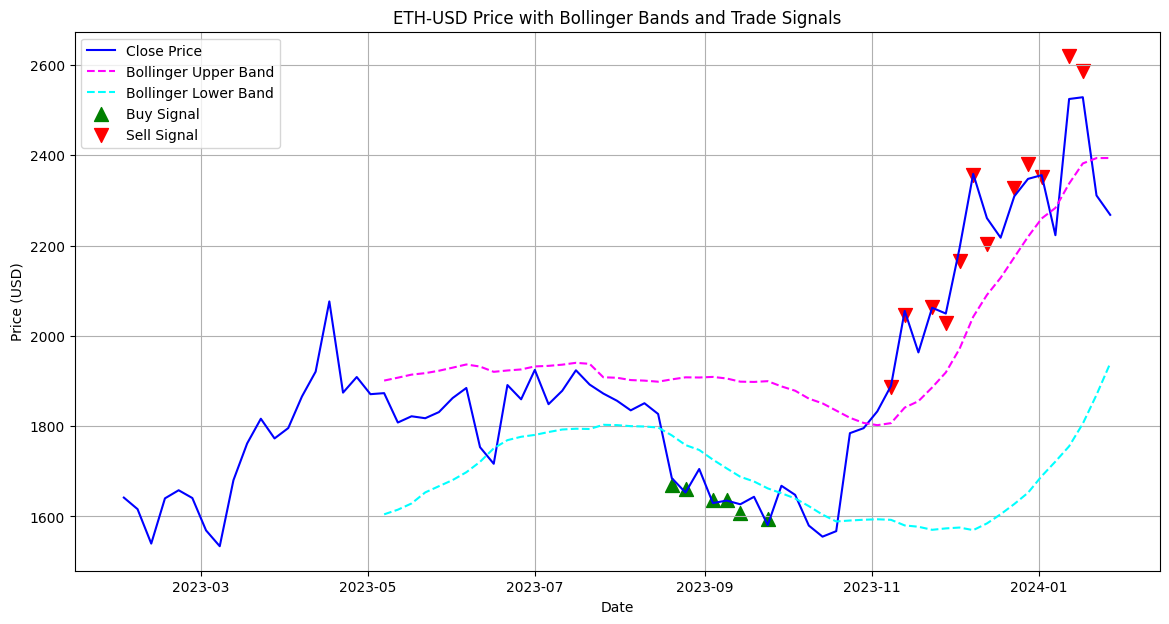

In [124]:
for crypto in cryptos:
    plot_trade_signals(five_day_data, crypto)

# Parameter V

In [147]:
five_day_data = calculate_bollinger_bands(five_day_data, cryptos, window=25, multiplier=1)
five_day_data = calculate_keltner_channels(five_day_data, cryptos, window=25, window_atr=14, multiplier=1)
five_day_data = calculate_RSI_pandas(five_day_data, cryptos, ob=70, os=30)
five_day_data = generate_trade_signals(five_day_data, cryptos)
signal_columns = [f'Buy_Signal_{crypto}' for crypto in cryptos] + [f'Sell_Signal_{crypto}' for crypto in cryptos]

print(five_day_data[signal_columns].tail())

initial_capital = 1000
results = backtest_strategy(five_day_data, cryptos, initial_capital=initial_capital)

for crypto, metrics in results.items():
    print(f"\nنتایج Backtest برای {crypto}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

                           Buy_Signal_BTC-USD  Buy_Signal_ETH-USD  \
Date                                                                
2024-01-07 00:00:00+00:00               False               False   
2024-01-12 00:00:00+00:00               False               False   
2024-01-17 00:00:00+00:00               False               False   
2024-01-22 00:00:00+00:00               False               False   
2024-01-27 00:00:00+00:00               False               False   

                           Sell_Signal_BTC-USD  Sell_Signal_ETH-USD  
Date                                                                 
2024-01-07 00:00:00+00:00                 True                False  
2024-01-12 00:00:00+00:00                False                 True  
2024-01-17 00:00:00+00:00                False                 True  
2024-01-22 00:00:00+00:00                False                False  
2024-01-27 00:00:00+00:00                False                False  
2023-08-20 - BTC-USD: خرید

<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '994.581203897333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value
<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '981.0565015648108' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value


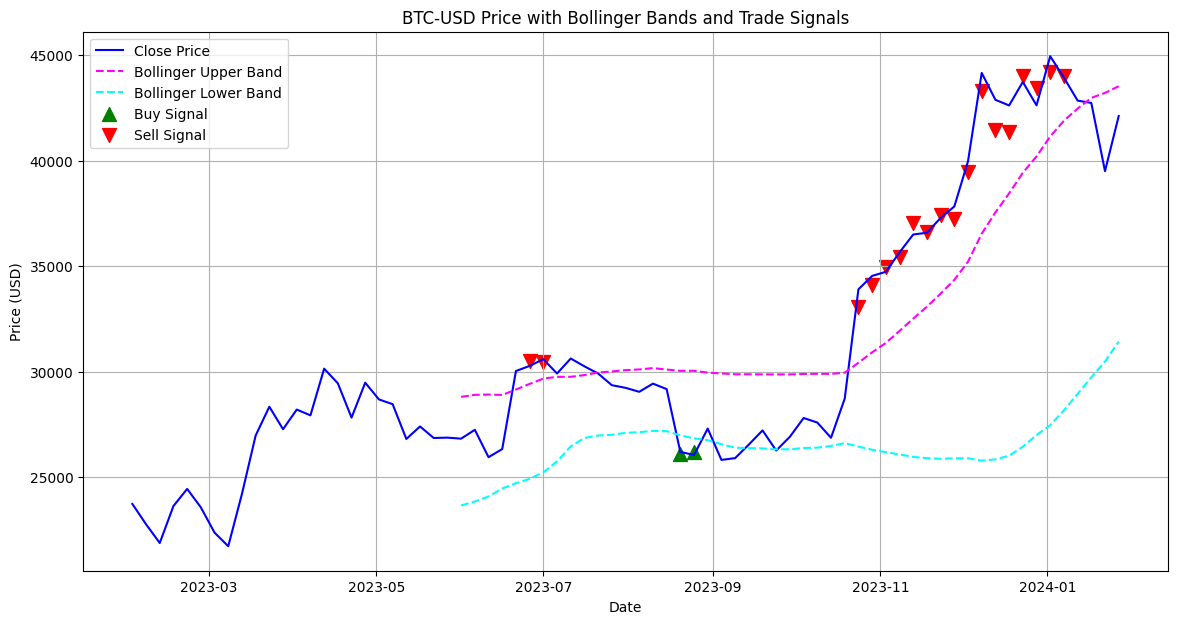

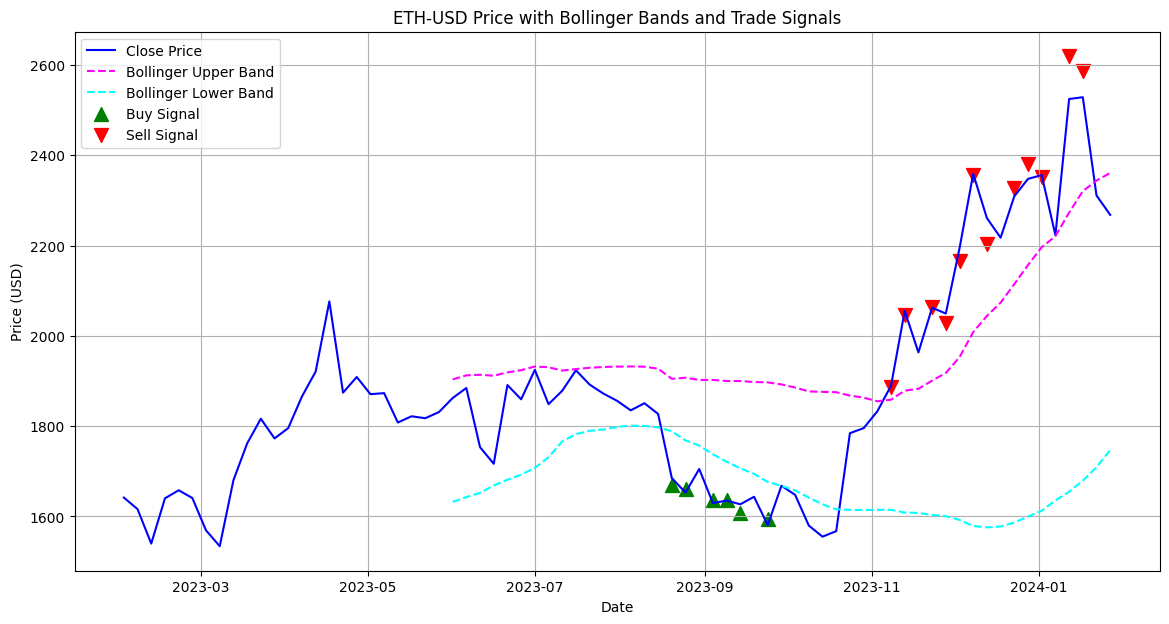

In [130]:
for crypto in cryptos:
    plot_trade_signals(five_day_data, crypto)

# Parameters VI

In [148]:
five_day_data = calculate_bollinger_bands(five_day_data, cryptos, window=25, multiplier=2.5)
five_day_data = calculate_keltner_channels(five_day_data, cryptos, window=25, window_atr=14, multiplier=2.5)
five_day_data = calculate_RSI_pandas(five_day_data, cryptos, ob=70, os=30)
five_day_data = generate_trade_signals(five_day_data, cryptos)
signal_columns = [f'Buy_Signal_{crypto}' for crypto in cryptos] + [f'Sell_Signal_{crypto}' for crypto in cryptos]

print(five_day_data[signal_columns].tail())

initial_capital = 1000
results = backtest_strategy(five_day_data, cryptos, initial_capital=initial_capital)

for crypto, metrics in results.items():
    print(f"\nنتایج Backtest برای {crypto}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

                           Buy_Signal_BTC-USD  Buy_Signal_ETH-USD  \
Date                                                                
2024-01-07 00:00:00+00:00               False               False   
2024-01-12 00:00:00+00:00               False               False   
2024-01-17 00:00:00+00:00               False               False   
2024-01-22 00:00:00+00:00               False               False   
2024-01-27 00:00:00+00:00               False               False   

                           Sell_Signal_BTC-USD  Sell_Signal_ETH-USD  
Date                                                                 
2024-01-07 00:00:00+00:00                False                False  
2024-01-12 00:00:00+00:00                False                False  
2024-01-17 00:00:00+00:00                False                False  
2024-01-22 00:00:00+00:00                False                False  
2024-01-27 00:00:00+00:00                False                False  
2023-08-25 - ETH-USD: خرید

<ipython-input-101-4bff43d23f00>:57: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1031.5663484491809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value


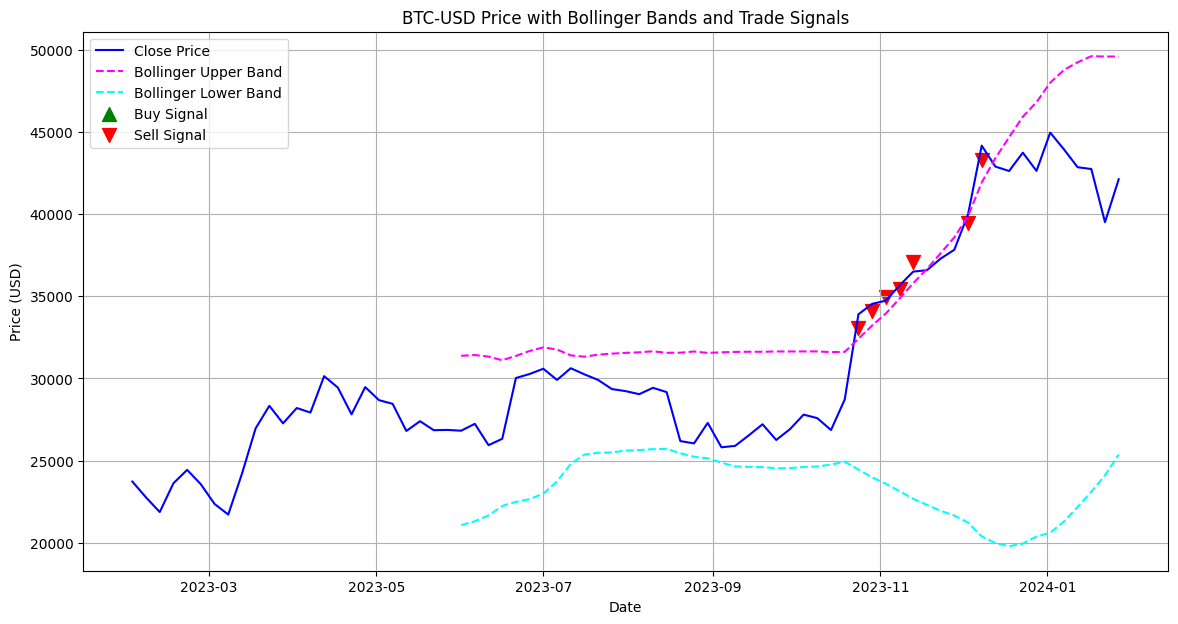

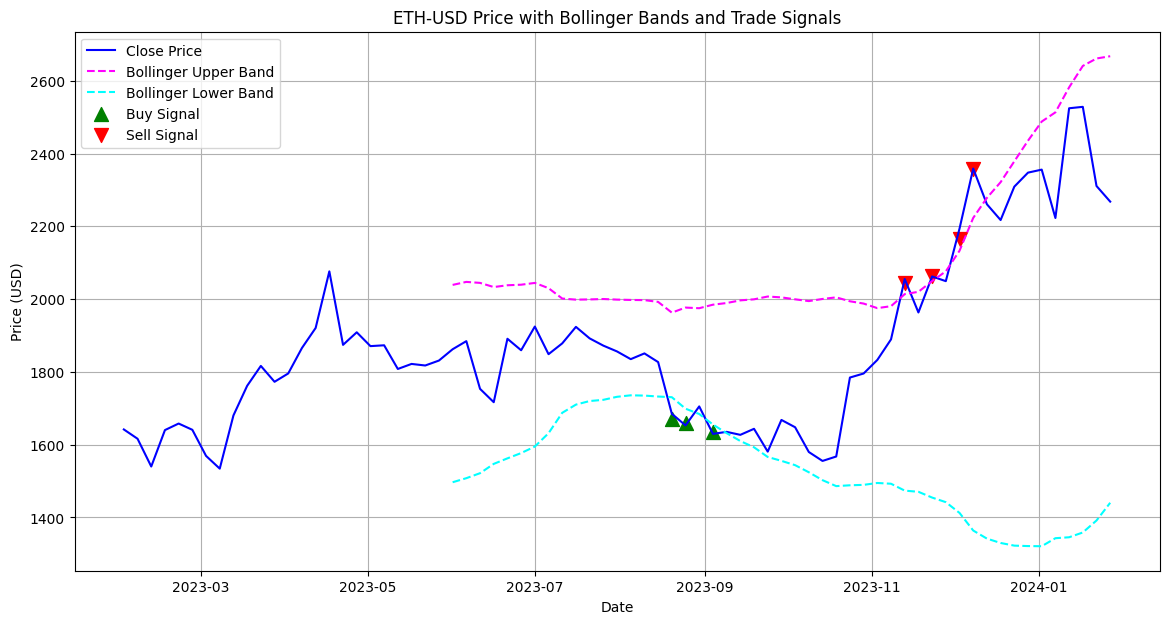

In [134]:
for crypto in cryptos:
    plot_trade_signals(five_day_data, crypto)

## Parameters VII

In [145]:
five_day_data = calculate_bollinger_bands(five_day_data, cryptos, window=5, multiplier=2.5)
five_day_data = calculate_keltner_channels(five_day_data, cryptos, window=5, window_atr=10, multiplier=2)
five_day_data = calculate_RSI_pandas(five_day_data, cryptos, window=5, ob=70, os=30)
five_day_data = generate_trade_signals(five_day_data, cryptos)
signal_columns = [f'Buy_Signal_{crypto}' for crypto in cryptos] + [f'Sell_Signal_{crypto}' for crypto in cryptos]

print(five_day_data[signal_columns].tail())

initial_capital = 1000
results = backtest_strategy(five_day_data, cryptos, initial_capital=initial_capital)

for crypto, metrics in results.items():
    print(f"\nنتایج Backtest برای {crypto}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

                           Buy_Signal_BTC-USD  Buy_Signal_ETH-USD  \
Date                                                                
2024-01-07 00:00:00+00:00               False               False   
2024-01-12 00:00:00+00:00               False               False   
2024-01-17 00:00:00+00:00               False               False   
2024-01-22 00:00:00+00:00               False               False   
2024-01-27 00:00:00+00:00               False               False   

                           Sell_Signal_BTC-USD  Sell_Signal_ETH-USD  
Date                                                                 
2024-01-07 00:00:00+00:00                False                False  
2024-01-12 00:00:00+00:00                False                False  
2024-01-17 00:00:00+00:00                False                False  
2024-01-22 00:00:00+00:00                False                False  
2024-01-27 00:00:00+00:00                False                False  

نتایج Backtest برای BTC-U

<ipython-input-101-4bff43d23f00>:57: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)


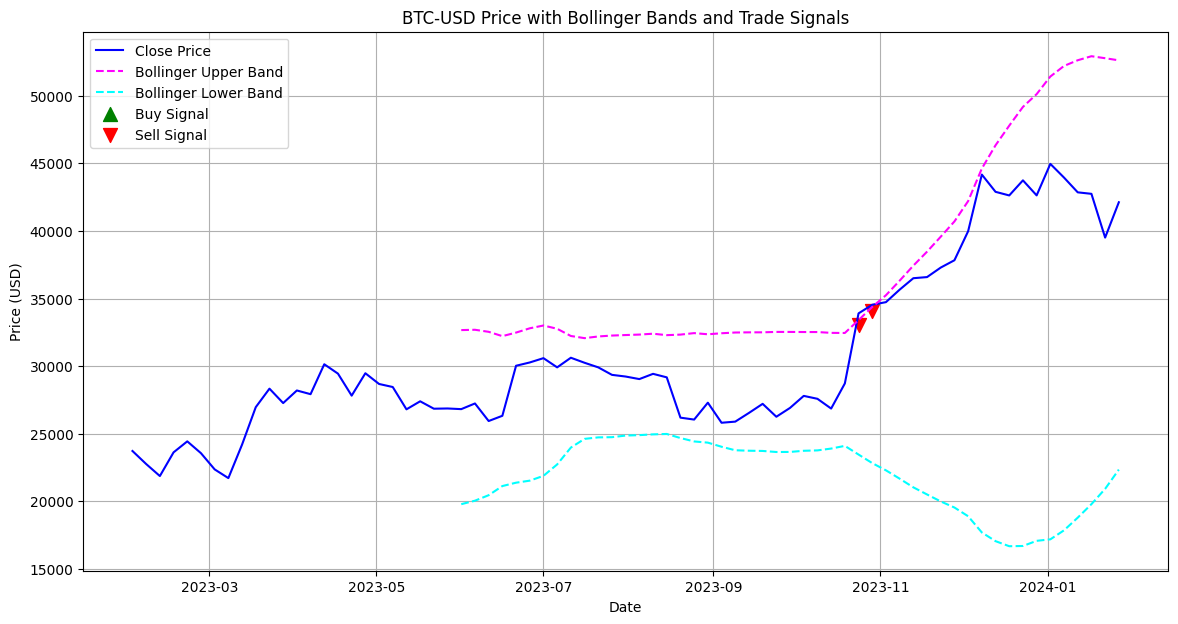

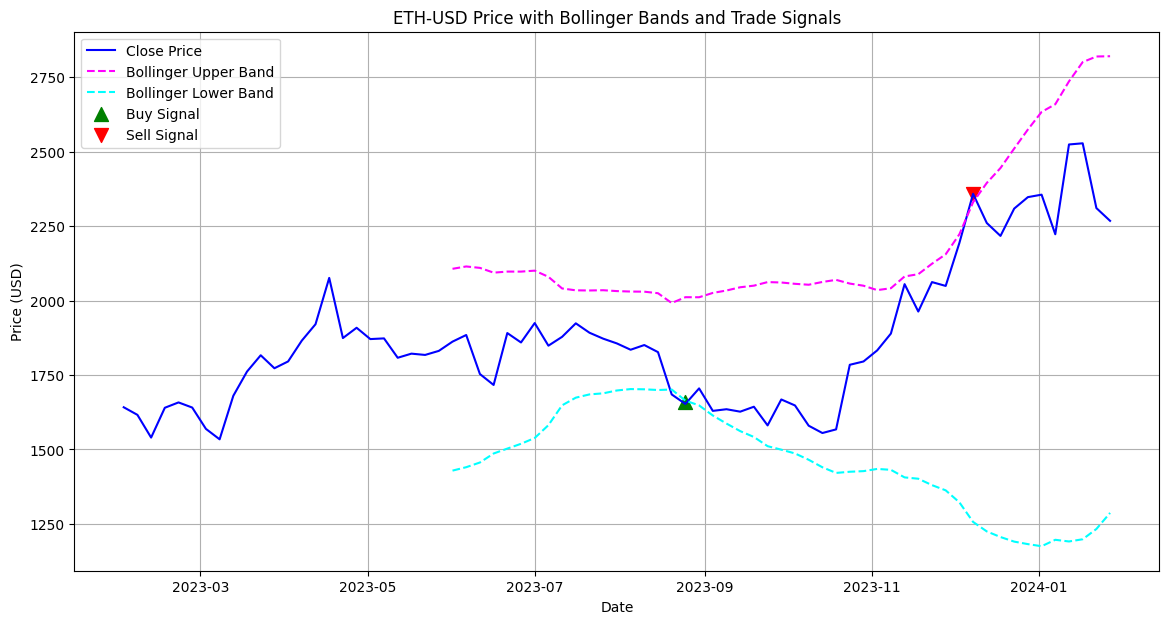

In [149]:
for crypto in cryptos:
    plot_trade_signals(five_day_data, crypto)

## Parametes VIII

In [140]:
five_day_data = calculate_bollinger_bands(five_day_data, cryptos, window=15, multiplier=0.5)
five_day_data = calculate_keltner_channels(five_day_data, cryptos, window=15, window_atr=15, multiplier=1.5)
five_day_data = calculate_RSI_pandas(five_day_data, cryptos, window=5, ob=70, os=30)
five_day_data = generate_trade_signals(five_day_data, cryptos)
signal_columns = [f'Buy_Signal_{crypto}' for crypto in cryptos] + [f'Sell_Signal_{crypto}' for crypto in cryptos]

print(five_day_data[signal_columns].tail())

initial_capital = 1000
results = backtest_strategy(five_day_data, cryptos, initial_capital=initial_capital)

for crypto, metrics in results.items():
    print(f"\nنتایج Backtest برای {crypto}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

                           Buy_Signal_BTC-USD  Buy_Signal_ETH-USD  \
Date                                                                
2024-01-07 00:00:00+00:00               False               False   
2024-01-12 00:00:00+00:00               False               False   
2024-01-17 00:00:00+00:00               False               False   
2024-01-22 00:00:00+00:00               False               False   
2024-01-27 00:00:00+00:00               False               False   

                           Sell_Signal_BTC-USD  Sell_Signal_ETH-USD  
Date                                                                 
2024-01-07 00:00:00+00:00                False                False  
2024-01-12 00:00:00+00:00                False                 True  
2024-01-17 00:00:00+00:00                False                 True  
2024-01-22 00:00:00+00:00                False                False  
2024-01-27 00:00:00+00:00                False                False  
2023-08-20 - BTC-USD: خرید

<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '994.581203897333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value
<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '981.0565015648108' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value


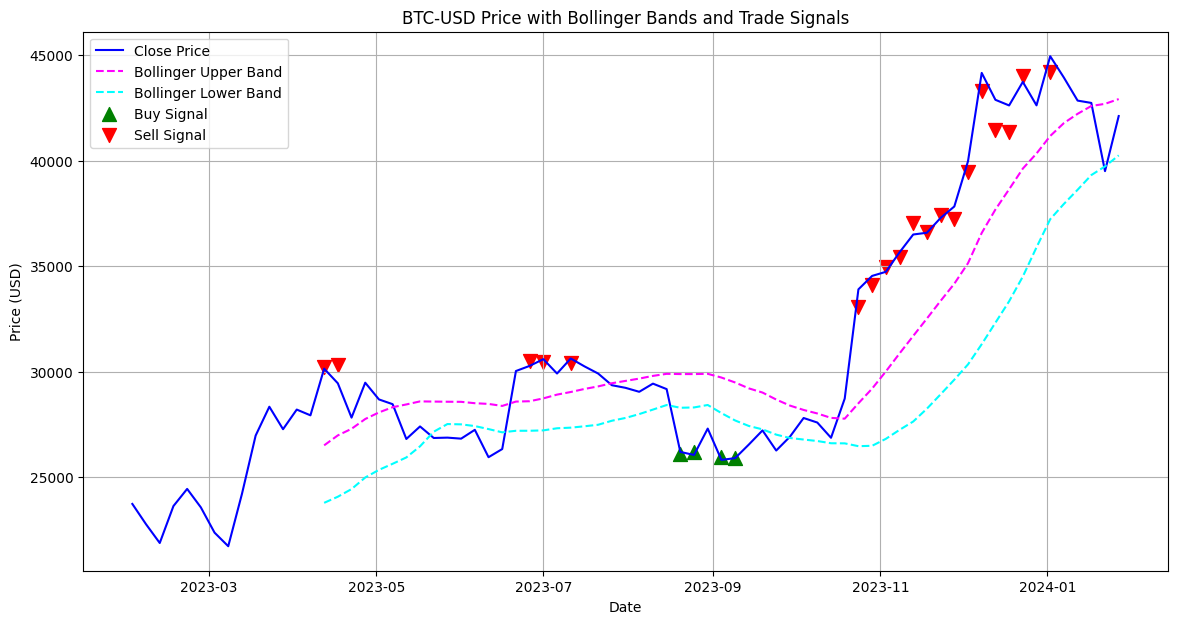

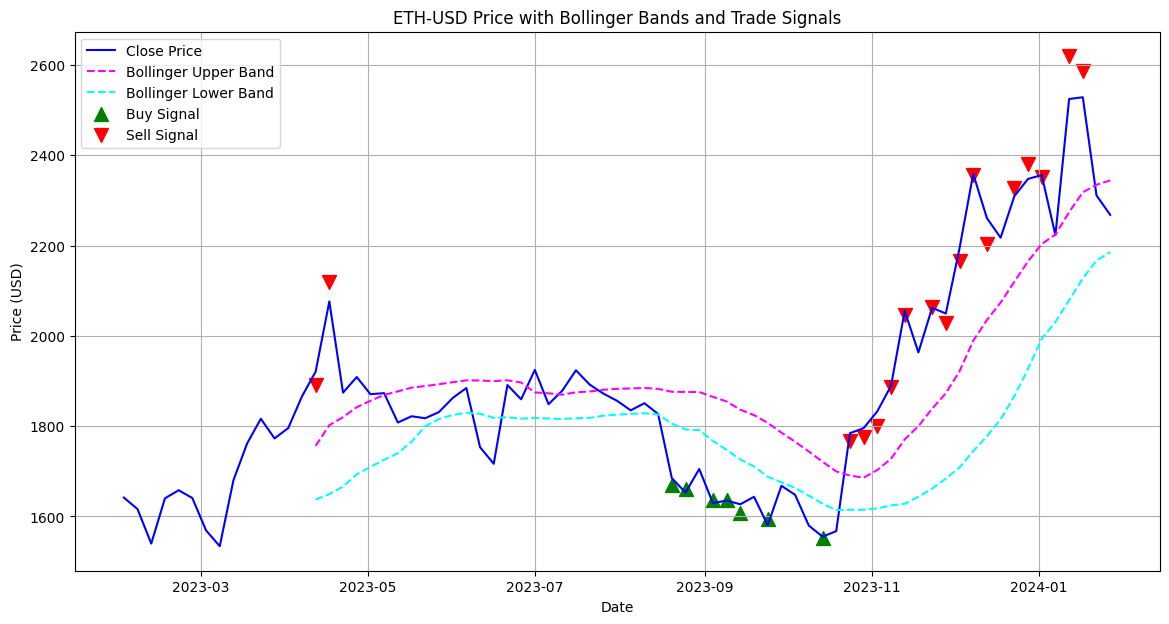

In [141]:
for crypto in cryptos:
    plot_trade_signals(five_day_data, crypto)

## Parameters IX

In [152]:
five_day_data = calculate_bollinger_bands(five_day_data, cryptos, window=15, multiplier=0.5)
five_day_data = calculate_keltner_channels(five_day_data, cryptos, window=15, window_atr=15, multiplier=1.5)
five_day_data = calculate_RSI_pandas(five_day_data, cryptos, window=5, ob=80, os=20)
five_day_data = generate_trade_signals(five_day_data, cryptos)
signal_columns = [f'Buy_Signal_{crypto}' for crypto in cryptos] + [f'Sell_Signal_{crypto}' for crypto in cryptos]

print(five_day_data[signal_columns].tail())

initial_capital = 1000
results = backtest_strategy(five_day_data, cryptos, initial_capital=initial_capital)

for crypto, metrics in results.items():
    print(f"\nنتایج Backtest برای {crypto}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

                           Buy_Signal_BTC-USD  Buy_Signal_ETH-USD  \
Date                                                                
2024-01-07 00:00:00+00:00               False               False   
2024-01-12 00:00:00+00:00               False               False   
2024-01-17 00:00:00+00:00               False               False   
2024-01-22 00:00:00+00:00               False               False   
2024-01-27 00:00:00+00:00               False               False   

                           Sell_Signal_BTC-USD  Sell_Signal_ETH-USD  
Date                                                                 
2024-01-07 00:00:00+00:00                False                False  
2024-01-12 00:00:00+00:00                False                False  
2024-01-17 00:00:00+00:00                False                False  
2024-01-22 00:00:00+00:00                False                False  
2024-01-27 00:00:00+00:00                False                False  
2023-08-20 - BTC-USD: خرید

<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '994.581203897333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value
<ipython-input-101-4bff43d23f00>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '981.0565015648108' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value


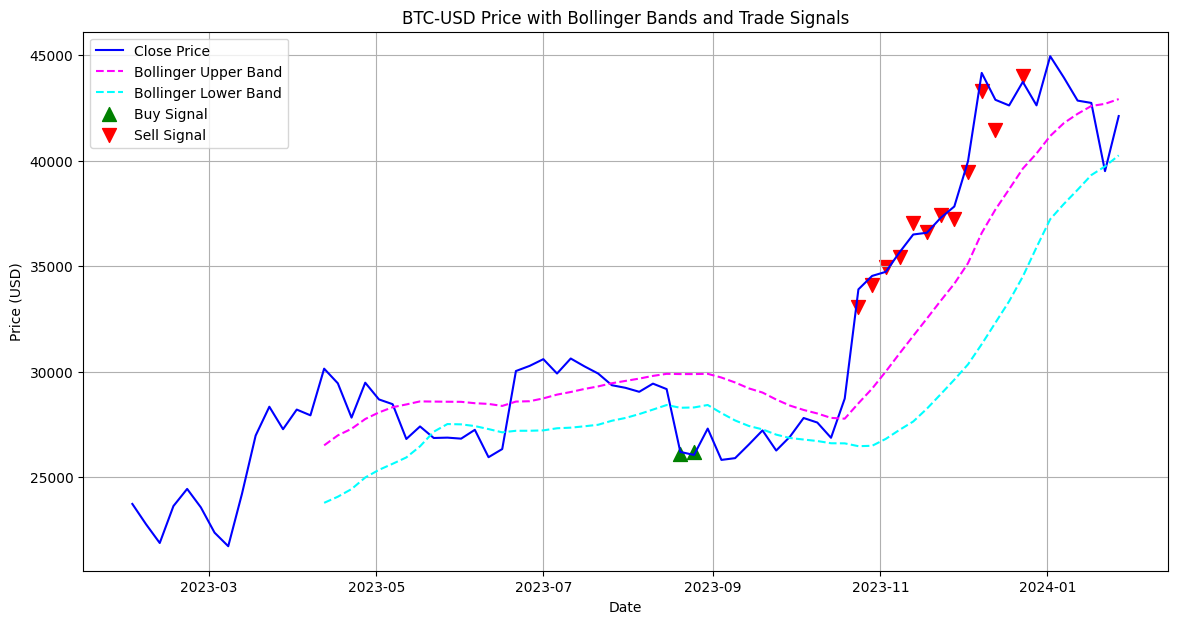

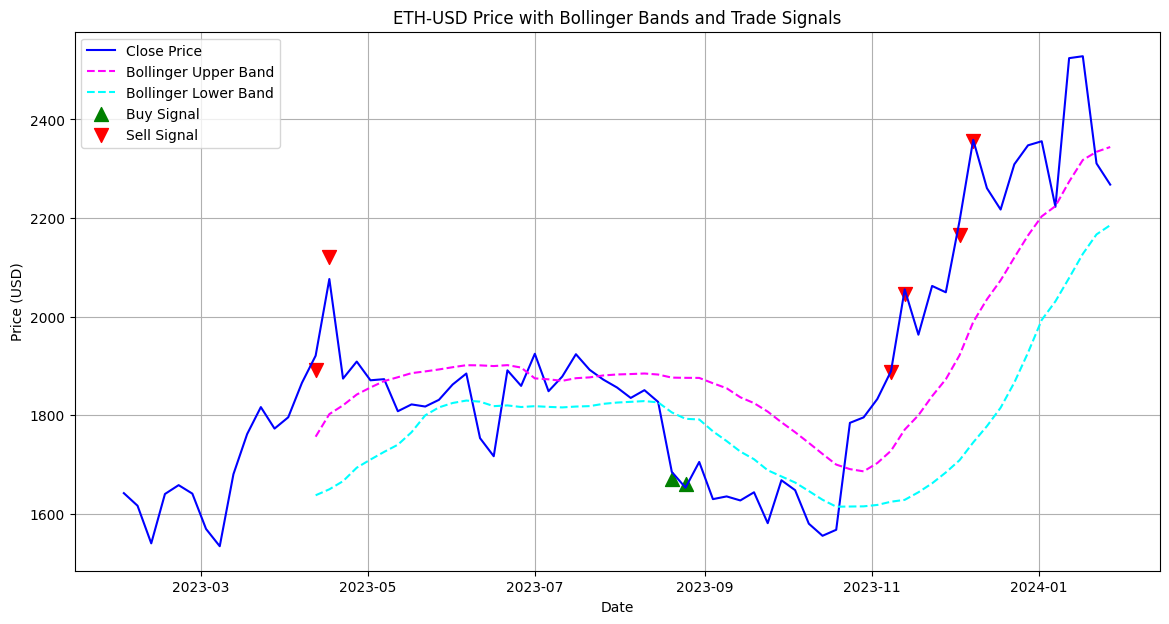

In [153]:
for crypto in cryptos:
    plot_trade_signals(five_day_data, crypto)

# Section 2

In [104]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns.mean() - risk_free_rate
    sharpe_ratio = excess_returns / returns.std() * np.sqrt(252)
    return sharpe_ratio

In [105]:
def calculate_sortino_ratio(returns, risk_free_rate=0.0):
    downside_returns = returns[returns < 0]
    if downside_returns.empty:
        return np.nan
    excess_returns = returns.mean() - risk_free_rate
    sortino_ratio = excess_returns / downside_returns.std() * np.sqrt(252)
    return sortino_ratio

In [106]:
def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min() * 100
    return max_drawdown

In [107]:
def calculate_net_profit(final_capital, initial_capital=2000):
    net_profit = final_capital - initial_capital
    return net_profit

In [108]:
def generate_trade_signals_bollinger(df, crypto):

    df[f'Buy_Signal_{crypto}'] = (df[f'Close_{crypto}'].shift(1) <= df[f'Lower_Band_{crypto}'])

    df[f'Sell_Signal_{crypto}'] = (df[f'Close_{crypto}'].shift(1) >= df[f'Upper_Band_{crypto}'])

    return df

In [109]:
def backtest_bollinger_strategy(df, crypto, initial_capital=2000):

    capital = initial_capital
    position = False
    shares = 0

    df[f'Portfolio_Value_{crypto}'] = initial_capital

    for idx, row in df.iterrows():
        buy_signal = row[f'Buy_Signal_{crypto}']
        sell_signal = row[f'Sell_Signal_{crypto}']
        open_price = row[f'Open_{crypto}']

        if buy_signal and not position:
            position = True
            shares = capital / open_price
            capital = 0
            portfolio_value = shares * open_price
            df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value
            print(f"{idx.date()} - {crypto}: خرید به قیمت {open_price:.2f} USD")

        elif sell_signal and position:
            position = False
            capital = shares * open_price
            shares = 0
            portfolio_value = capital
            df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value
            print(f"{idx.date()} - {crypto}: فروش به قیمت {open_price:.2f} USD")

        else:
            if position:
                portfolio_value = shares * open_price
            else:
                portfolio_value = capital
            df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value

    if position:
        sell_price = df[f'Open_{crypto}'].iloc[-1]
        capital = shares * sell_price
        df.at[df.index[-1], f'Portfolio_Value_{crypto}'] = capital
        print(f"{df.index[-1].date()} - {crypto}: فروش نهایی به قیمت {sell_price:.2f} USD")

    df[f'Returns_{crypto}'] = df[f'Portfolio_Value_{crypto}'].pct_change().fillna(0)

    df[f'Cumulative_Returns_{crypto}'] = (1 + df[f'Returns_{crypto}']).cumprod()

    total_return = df[f'Cumulative_Returns_{crypto}'].iloc[-1] - 1
    final_capital = df[f'Portfolio_Value_{crypto}'].iloc[-1]
    net_profit = calculate_net_profit(final_capital, initial_capital)
    sharpe_ratio = calculate_sharpe_ratio(df[f'Returns_{crypto}'])
    sortino_ratio = calculate_sortino_ratio(df[f'Returns_{crypto}'])
    max_drawdown = calculate_max_drawdown(df[f'Cumulative_Returns_{crypto}'])

    results = {
        'Total Return (%)': total_return * 100,
        'Net Profit ($)': net_profit,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown (%)': max_drawdown
    }

    return results

In [110]:
def download_data(cryptos, start_date, end_date, interval='1d'):

    df = yf.download(cryptos, start=start_date, end=end_date, interval=interval)

    df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df.columns]
    return df

In [111]:
def plot_trade_signals(df, crypto):

    plt.figure(figsize=(14, 7))

    plt.plot(df.index, df[f'Close_{crypto}'], label='Close Price', color='blue')

    plt.plot(df.index, df[f'Upper_Band_{crypto}'], label='Bollinger Upper Band', color='magenta', linestyle='--')
    plt.plot(df.index, df[f'Lower_Band_{crypto}'], label='Bollinger Lower Band', color='cyan', linestyle='--')

    buy_signals = df[df[f'Buy_Signal_{crypto}']]
    plt.scatter(buy_signals.index, buy_signals[f'Open_{crypto}'], marker='^', color='green', label='Buy Signal', s=100)

    sell_signals = df[df[f'Sell_Signal_{crypto}']]
    plt.scatter(sell_signals.index, sell_signals[f'Open_{crypto}'], marker='v', color='red', label='Sell Signal', s=100)

    plt.title(f'{crypto} Price with Bollinger Bands and Trade Signals')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [112]:
def run_strategy(crypto='BTC-USD', initial_capital=2000, start_date='2023-02-01', end_date='2024-02-01', interval='1d'):

    df = download_data([crypto], start_date, end_date, interval=interval)

    df = calculate_bollinger_bands(df, [crypto], window=20, multiplier=2)

    df = generate_trade_signals_bollinger(df, crypto)

    results = backtest_bollinger_strategy(df, crypto, initial_capital=initial_capital)

    print("\nمعیارهای ارزیابی Backtest:")
    for metric, value in results.items():
        print(f"{metric}: {value:.2f}")

    plot_trade_signals(df, crypto)

[*********************100%***********************]  1 of 1 completed
<ipython-input-109-6948021afa58>:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1982.410273204445' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value


2023-03-10 - BTC-USD: خرید به قیمت 20367.00 USD
2023-03-18 - BTC-USD: فروش به قیمت 27448.12 USD
2023-06-06 - BTC-USD: خرید به قیمت 25732.11 USD
2023-06-22 - BTC-USD: فروش به قیمت 29995.94 USD
2023-08-18 - BTC-USD: خرید به قیمت 26636.08 USD
2023-09-20 - BTC-USD: فروش به قیمت 27210.23 USD

معیارهای ارزیابی Backtest:
Total Return (%): 60.48
Net Profit ($): 1209.70
Sharpe Ratio: 1.86
Sortino Ratio: 1.70
Max Drawdown (%): -9.25


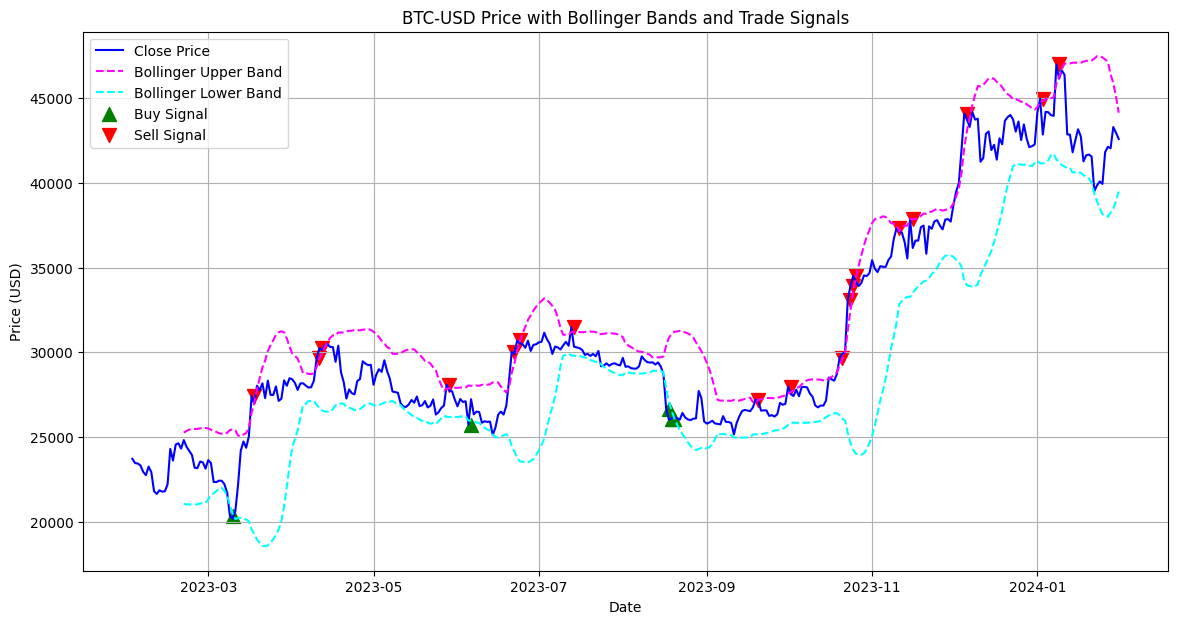

[*********************100%***********************]  1 of 1 completed
<ipython-input-109-6948021afa58>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1999.9999999999998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value


2023-03-10 - ETH-USD: خرید به قیمت 1438.76 USD
2023-04-06 - ETH-USD: فروش به قیمت 1909.14 USD
2023-06-11 - ETH-USD: خرید به قیمت 1752.53 USD
2023-07-14 - ETH-USD: فروش به قیمت 2005.69 USD
2023-08-18 - ETH-USD: خرید به قیمت 1682.04 USD
2023-10-02 - ETH-USD: فروش به قیمت 1732.98 USD

معیارهای ارزیابی Backtest:
Total Return (%): 56.46
Net Profit ($): 1129.23
Sharpe Ratio: 1.63
Sortino Ratio: 1.61
Max Drawdown (%): -10.30


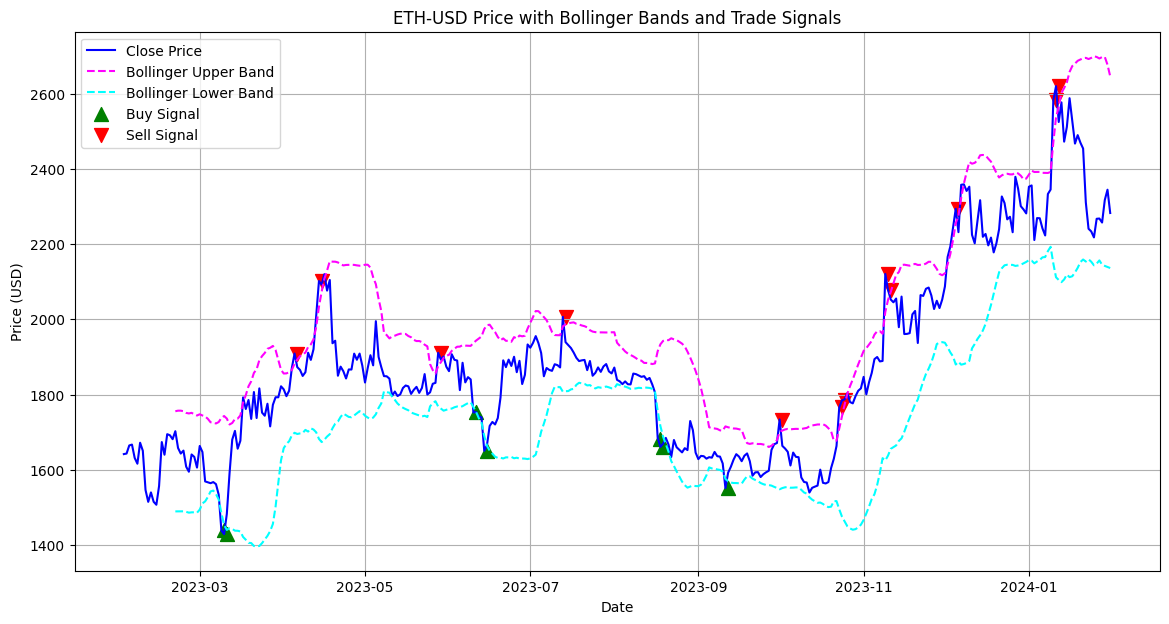

In [113]:
run_strategy(crypto='BTC-USD', initial_capital=2000, start_date='2023-02-01', end_date='2024-02-01', interval='1d')
run_strategy(crypto='ETH-USD', initial_capital=2000, start_date='2023-02-01', end_date='2024-02-01', interval='1d')

In [125]:
def backtest_bollinger_strategy_with_risk_management(df, crypto, initial_capital=2000, risk_percentage=0.4):
    capital = initial_capital
    position = False
    shares = 0

    df[f'Portfolio_Value_{crypto}'] = initial_capital

    for idx, row in df.iterrows():
        buy_signal = row[f'Buy_Signal_{crypto}']
        sell_signal = row[f'Sell_Signal_{crypto}']
        open_price = row[f'Open_{crypto}']

        if buy_signal and not position:
            position = True
            investment = capital * risk_percentage
            shares = investment / open_price
            capital -= investment
            portfolio_value = shares * open_price
            df.at[idx, f'Portfolio_Value_{crypto}'] = capital + portfolio_value
            print(f"{idx.date()} - {crypto}: خرید {shares:.4f} سهم به قیمت {open_price:.2f} USD")

        elif sell_signal and position:
            position = False
            proceeds = shares * open_price
            capital += proceeds
            shares = 0
            portfolio_value = capital
            df.at[idx, f'Portfolio_Value_{crypto}'] = portfolio_value
            print(f"{idx.date()} - {crypto}: فروش به قیمت {open_price:.2f} USD و کسب {proceeds:.2f} USD")

        else:
            if position:
                portfolio_value = shares * open_price
                df.at[idx, f'Portfolio_Value_{crypto}'] = capital + portfolio_value
            else:
                df.at[idx, f'Portfolio_Value_{crypto}'] = capital

    if position:
        sell_price = df[f'Open_{crypto}'].iloc[-1]
        proceeds = shares * sell_price
        capital += proceeds
        df.at[df.index[-1], f'Portfolio_Value_{crypto}'] = capital
        print(f"{df.index[-1].date()} - {crypto}: فروش نهایی به قیمت {sell_price:.2f} USD و کسب {proceeds:.2f} USD")

    df[f'Returns_{crypto}'] = df[f'Portfolio_Value_{crypto}'].pct_change().fillna(0)

    df[f'Cumulative_Returns_{crypto}'] = (1 + df[f'Returns_{crypto}']).cumprod()

    total_return = df[f'Cumulative_Returns_{crypto}'].iloc[-1] - 1
    final_capital = df[f'Portfolio_Value_{crypto}'].iloc[-1]
    net_profit = calculate_net_profit(final_capital, initial_capital)
    sharpe_ratio = calculate_sharpe_ratio(df[f'Returns_{crypto}'])
    sortino_ratio = calculate_sortino_ratio(df[f'Returns_{crypto}'])
    max_drawdown = calculate_max_drawdown(df[f'Cumulative_Returns_{crypto}'])

    results = {
        'Total Return (%)': total_return * 100,
        'Net Profit ($)': net_profit,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown (%)': max_drawdown
    }

    return results

In [126]:
def run_strategy(crypto='BTC-USD', initial_capital=2000, start_date='2023-02-01', end_date='2024-02-01', interval='1d'):

    df = download_data([crypto], start_date, end_date, interval=interval)

    df = calculate_bollinger_bands(df, [crypto], window=20, multiplier=2)

    df = generate_trade_signals_bollinger(df, crypto)

    results = backtest_bollinger_strategy_with_risk_management(df, crypto, initial_capital=initial_capital, risk_percentage=0.4)

    print("\nمعیارهای ارزیابی Backtest:")
    for metric, value in results.items():
        print(f"{metric}: {value:.2f}")

    plot_trade_signals(df, crypto)

[*********************100%***********************]  1 of 1 completed
<ipython-input-125-92b0ff37ea2f>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1992.964109281778' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = capital + portfolio_value


2023-03-10 - BTC-USD: خرید 0.0393 سهم به قیمت 20367.00 USD
2023-03-18 - BTC-USD: فروش به قیمت 27448.12 USD و کسب 1078.14 USD
2023-06-06 - BTC-USD: خرید 0.0354 سهم به قیمت 25732.11 USD
2023-06-22 - BTC-USD: فروش به قیمت 29995.94 USD و کسب 1062.25 USD
2023-08-18 - BTC-USD: خرید 0.0365 سهم به قیمت 26636.08 USD
2023-09-20 - BTC-USD: فروش به قیمت 27210.23 USD و کسب 992.60 USD

معیارهای ارزیابی Backtest:
Total Return (%): 22.50
Net Profit ($): 450.08
Sharpe Ratio: 1.86
Sortino Ratio: 1.74
Max Drawdown (%): -3.79


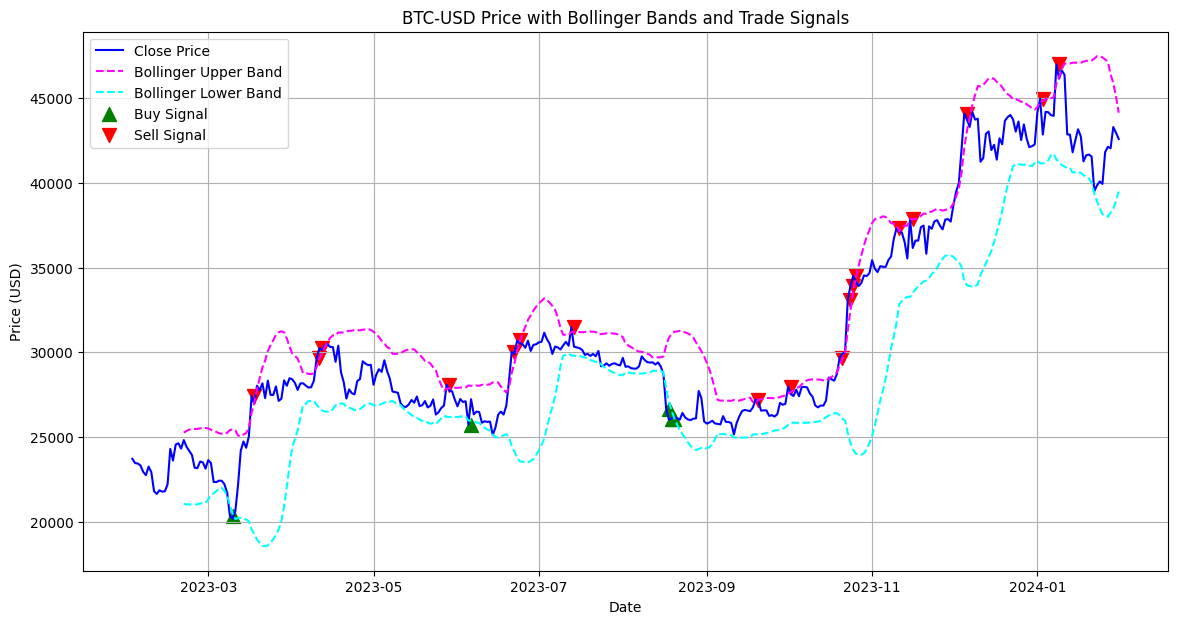

[*********************100%***********************]  1 of 1 completed
<ipython-input-125-92b0ff37ea2f>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1994.6290967929522' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, f'Portfolio_Value_{crypto}'] = capital + portfolio_value


2023-03-10 - ETH-USD: خرید 0.5560 سهم به قیمت 1438.76 USD
2023-04-06 - ETH-USD: فروش به قیمت 1909.14 USD و کسب 1061.55 USD
2023-06-11 - ETH-USD: خرید 0.5162 سهم به قیمت 1752.53 USD
2023-07-14 - ETH-USD: فروش به قیمت 2005.69 USD و کسب 1035.30 USD
2023-08-18 - ETH-USD: خرید 0.5689 سهم به قیمت 1682.04 USD
2023-10-02 - ETH-USD: فروش به قیمت 1732.98 USD و کسب 985.87 USD

معیارهای ارزیابی Backtest:
Total Return (%): 21.06
Net Profit ($): 421.21
Sharpe Ratio: 1.60
Sortino Ratio: 1.56
Max Drawdown (%): -4.19


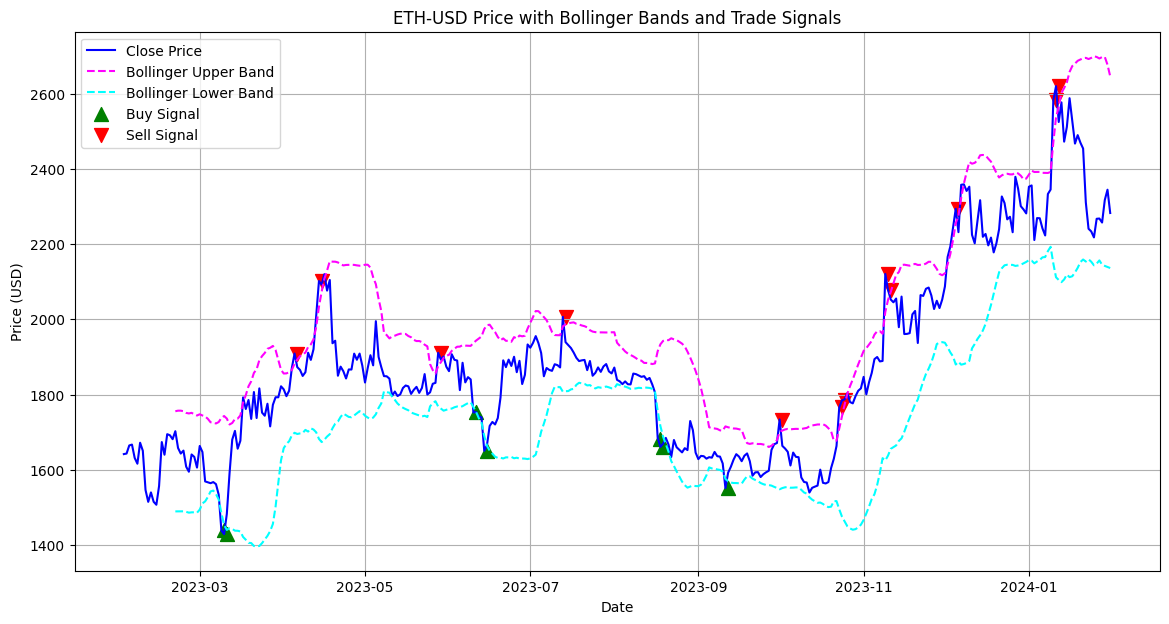

In [128]:
run_strategy(crypto='BTC-USD', initial_capital=2000, start_date='2023-02-01', end_date='2024-02-01', interval='1d')
run_strategy(crypto='ETH-USD', initial_capital=2000, start_date='2023-02-01', end_date='2024-02-01', interval='1d')